# Contributors
Zijian Zhang 14851598 $\\$
Amish Sewlal 13297503 $\\$
Ravi Sharma Kaushik 14332744

# Creating Mandlebrot Set

# Area of Mandlebrot Set using Monte Carlo Method

# Convergence studies for various number of iterations and samples

# Using varous sampling techniques  

# Approach for improving convergence

In [27]:
import math
import matplotlib.pyplot as plt
import numpy as np
from Mandelbrot_h import whenLeaveMandelbrotSet as wlms, randomSampling_h as RS_h, latinHypercubeSampling_h as LHS_h, orthogonalSampling_h as OS_h
import scipy.stats as stats

In [9]:
# Try to compute the exact value of A_M
i = 1000
s = int(1e7)
A_h_LHSC = LHS_circle(i, s, R=2)
print(A_h_LHSC[-1])

1.5105242434172457


In [133]:
def RS_circle(iter_num: int, s_num: int, R: int = 2) -> np.ndarray:
    '''Compute the area of the Mandelbrot set by pure random sampling within a circle.
    Parameters:
        iter_num: the number of iterations (i)
        s_num: the number of samples (s)
        R: the radius of the circle
    Returns:
        A_h: the areas of the Mandelbrot set during the run
    '''
    history = np.zeros((s_num, iter_num))
    # history is the historical data for all samples at each step in the iteration
    for s in range(s_num):
        U1 = np.random.uniform(0, 1)
        U2 = np.random.uniform(0, 1)
        theta = U1 * 2 * math.pi
        r = R * math.sqrt(U2)
        real = r * math.cos(theta)
        imag = r * math.sin(theta)
        c = complex(real, imag)
        j = wlms(c, iter_num)
        # j is the iteration number when c leave the Mandelbrot set
        # If c never leave the Mandelbrot set, j = iter_num
        history[s, :j] = 1

    # Compute the area of the Mandelbrot set
    N_h = history.sum(axis=0)
    # N_h is the number of samples that are in the Mandelbrot set during the run
    A_total = math.pi * R**2  # The area of the sampling region
    A_h = N_h / s_num * A_total

    return A_h


def LHS_circle(iter_num: int, s_num: int, R: int = 2) -> np.ndarray:
    '''Compute the area of the Mandelbrot set by Latin hypercube sampling within a circle.
    Parameters:
        iter_num: the number of iterations (i)
        s_num: the number of samples (s)
        R: the radius of the circle
    Returns:
        A_h: the areas of the Mandelbrot set during the run
    '''
    idx = np.arange(s_num)
    np.random.shuffle(idx)
    history = np.zeros((s_num, iter_num))
    # history is the historical data for all samples at each step in the iteration
    for s in range(s_num):
        U1 = np.random.uniform(0, 1)
        U2 = np.random.uniform(0, 1)
        # Split the circular sampling region into s sectors, and get the RV: theta
        theta = 2 * math.pi * (s + U1) / s_num
        # Divide the sector into s equal parts of equal area, and get the RV: r
        r = R * math.sqrt((idx[s] + U2) / s_num)
        real = r * math.cos(theta)
        imag = r * math.sin(theta)
        c = complex(real, imag)
        j = wlms(c, iter_num)
        # j is the iteration number when c leave the Mandelbrot set
        # If c never leave the Mandelbrot set, j = iter_num
        history[s, :j] = 1

    # Compute the areas of the Mandelbrot set during the run
    N_h = history.sum(axis=0)
    # N_h is the number of samples that are in the Mandelbrot set during the run
    A_total = math.pi * R**2  # The area of the sampling region
    A_h = N_h / s_num * A_total

    return A_h


def OS_circle(iter_num: int, s_num: int, R: int = 2) -> np.ndarray:
    '''Compute the area of the Mandelbrot set by orthogonal sampling within a circle.
    Parameters:
        iter_num: the number of iterations (i)
        s_num: the number of samples (s)
        R: the radius of the circle
    Returns:
        A_h: the areas of the Mandelbrot set during the run
    '''
    # Radius of the sampling region
    R = 2

    # Samples has to be a perfect square
    sqr = int(np.floor(np.sqrt(s_num)))
    s_num = sqr**2

    # Create array with minor sectors
    sectors = np.linspace(0, 2 * math.pi, s_num)

    # Randomly shuffle minor sectors
    np.random.shuffle(sectors)

    # Creating major rings
    rings = R * np.sqrt(np.linspace(0, 1, sqr + 1))

    # Creating the historical data for all samples at each step in the iteration
    history = np.zeros((s_num, iter_num))

    # Looping through each major ring
    for i in range(len(rings) - 1):
        # Creating array with minor rings in current
        minor_rings = rings[i * sqr:(i + 1) * sqr - 1]

        # Shuffling minor rings
        np.random.shuffle(minor_rings)

        # Looping through each minor ring
        for j in range(len(minor_rings)):
            # Creating complex number
            s = sqr * i + j
            theta = sectors[s]
            l = minor_rings[j]
            real = l * math.cos(theta)
            imag = l * math.sin(theta)
            c = complex(real, imag)

            # Adding to mandelbrot
            # j is the iteration number when c leave the Mandelbrot set
            # If c never leave the Mandelbrot set, j = iter_num
            j = wlms(c, iter_num)
            history[s, :j] = 1

    # Computing the number of samples that are in the Mandelbrot set during the run
    N_h = history.sum(axis=0)

    # Computing the area of the sampling region
    A_total = math.pi * R**2

    # Computing the areas during the run
    A_h = N_h / s_num * A_total

    return A_h


# TODO
def HS_circle():
    '''Compute the area of the Mandelbrot set by heuristic sampling within a circle.
    Parameters:
        
    Returns:
        A_h: the areas of the Mandelbrot set during the run
    '''
    pass

In [ ]:
# Pseudo code for heuristic sampling

# def wlms(i, c):
#     # 您已经实现的函数
#     pass

# # 步骤 1: 初步估计边缘
# # 这里需要您根据 wlms 函数的实现来完成

# # 步骤 2: 定义采样密度函数
# # 这个函数应该基于 wlms 的返回值来设计

# # 步骤 3: 进行重要性采样
# samples = 10000  # 采样数量
# max_iter = 100  # 最大迭代次数
# count = 0
# total_weight = 0

# for _ in range(samples):
#     # 在采样区域内随机选择一个点
#     real = np.random.uniform(-2, 2)
#     imag = np.random.uniform(-2, 2)
#     c = complex(real, imag)

#     # 计算 wlms 和采样权重
#     j = wlms(max_iter, c)
#     weight = ...  # 根据 j 值计算权重

#     # 判断是否属于 Mandelbrot 集并记录结果
#     if j+1 > max_iter:
#         count += weight
#     total_weight += weight

# # 步骤 4: 估计面积
# area_estimate = (count / total_weight) * 16  # 16 是采样区域的面积 (-2 到 2 的正方形)
# print("Estimated area of the Mandelbrot set:", area_estimate)

The first j that achieves the expect accuracy:
RSC: 454
LHSC: 470
OSC: 216


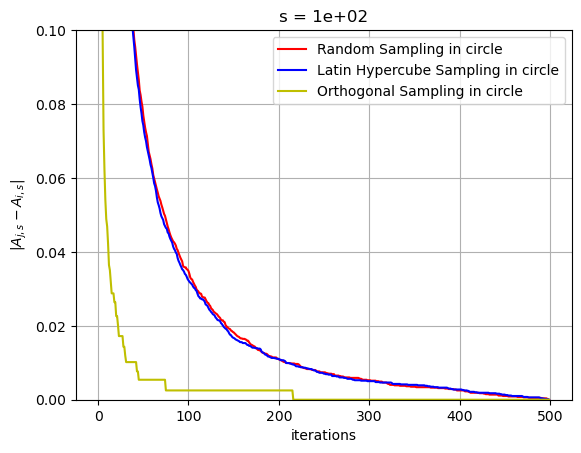

In [136]:
# Compare the convergence rate of the two methods
i = 500
s = 100
x = np.arange(i)

# 1 for random sampling, 2 for Latin hypercube sampling, 3 for orthogonal sampling
y1, y2, y3 = [], [], []
for j in range(1000):
    A_h1 = RS_circle(i, s, R=2)
    A_h2 = LHS_circle(i, s, R=2)
    A_h3 = OS_circle(i, s, R=2)
    y1.append(np.abs(A_h1 - A_h1[-1]))
    y2.append(np.abs(A_h2 - A_h2[-1]))
    y3.append(np.abs(A_h3 - A_h3[-1]))
mean1 = np.mean(y1, axis=0)
mean2 = np.mean(y2, axis=0)
mean3 = np.mean(y3, axis=0)

print("The first j that achieves the expect accuracy:")
expect_acc = 1e-3  # Expected accuracy
print("RSC:", np.where(mean1 <= expect_acc)[0][0])
print("LHSC:", np.where(mean2 <= expect_acc)[0][0])
print("OSC:", np.where(mean3 <= expect_acc)[0][0])

plt.figure()
plt.plot(x, mean1, label="Random Sampling in circle", c='r')
plt.plot(x, mean2, label="Latin Hypercube Sampling in circle", c='b')
plt.plot(x, mean3, label="Orthogonal Sampling in circle", c='y')
plt.ylim(0, 0.1)
plt.xlabel("iterations")
plt.ylabel(r"$|A_{j,s}-A_{i,s}|$")
plt.title("s = {:.0e}".format(s))
plt.legend()
plt.grid(True)
plt.show()

The first j that achieves the expect accuracy:
OS: 202
OSC: 141


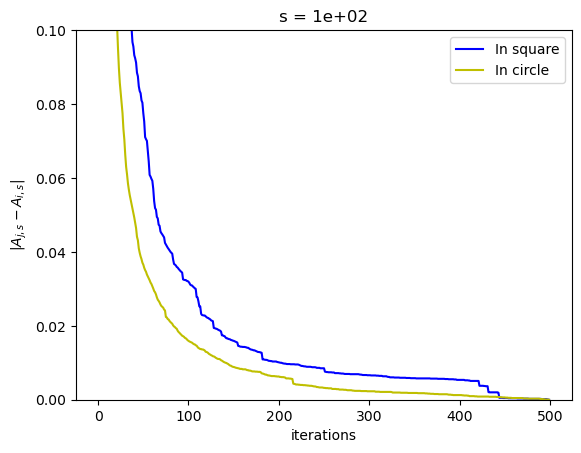

In [139]:
# Compare the convergence rate of the two orthogonal methods with constant s
i = 500  # Max iterations
s = 100  # s is constant
x = np.arange(i)
l = np.sqrt(4 * math.pi) / 2  # Make the sampling area the same size

# 1 for in square, 2 for in circle
y1, y2
for k in range(1000):
    A_h1 = OS_h(-l, l, i, s)
    A_h2 = OS_circle(i, s, R=2)
    y1.append(np.abs(A_h1 - A_h1[-1]))
    y2.append(np.abs(A_h2 - A_h2[-1]))
mean1 = np.mean(y1, axis=0)
mean2 = np.mean(y2, axis=0)

print("The first j that achieves the expect accuracy:")
expect_acc = 0.01  # Expected accuracy
print("OS:", np.where(mean1 <= expect_acc)[0][0])
print("OSC:", np.where(mean2 <= expect_acc)[0][0])

plt.figure()
plt.plot(x, mean1, label="In square", c='b')
plt.plot(x, mean2, label="In circle", c='y')
plt.xlabel("iterations")
plt.ylabel(r"$|A_{j,s}-A_{i,s}|$")
plt.title("s = {:.0e}".format(s))
plt.ylim(0, 0.1)
plt.legend()
plt.show()
# New methods look better than the previous three